# Becoming a Backprop Ninja
* You need to understand backpropagation, because it is a leaky abstraction
* We already covered backpropagation for the scalar case, by implementing micrograd
* But we need to expand this knowledge to tensors
* We will use the same neural network as in the last lecture, but this time we will implement the backward pass manually

## The Neural Network

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = list(sorted(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
vocab_size = len(stoi)
itos = {i:s for s,i in stoi.items()}
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [52]:
# build the dataset
block_size = 3
def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * 3
        for c in w+'.':
            xi = stoi[c]
            X.append(context)
            Y.append(xi)
            context = context[1:]+[xi]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr=build_dataset(words[0:n1])
Xval,Yval=build_dataset(words[n1:n2])
Xtest, Ytest=build_dataset(words[n2:])


* A new utility function is introduced that compares our manual gradient computations with pytorch computed ones

In [5]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max()
    print(f'{s:15s} | exact {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd)               , generator = g)
W1 = torch.randn((block_size*n_embd, n_hidden)     , generator = g) * 5/3 / ((block_size*n_embd)**0.5) # kaimin initialization to avoid contraction
b1 = torch.randn((n_hidden)                        , generator = g) * 0.1
W2 = torch.randn((n_hidden, vocab_size)            , generator = g) * 0.1  # make less confident
b2 = torch.randn((vocab_size)                      , generator = g) * 0.1  # not zero to unmask gradient errors

bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


* We will do a single forward pass and for this calculate one batch

In [7]:
batch_size = 32
n = batch_size # shorter name for use in expressions
xi = torch.randint(0, len(words), (batch_size, ), generator = g)
Xb, Yb = Xtr[xi], Ytr[xi]

In [8]:

# forward pass "chunkated" into smaller steps that are possible to backward one at a time
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# Linear Layer 1
hprebn = embcat @ W1 + b1
# Batchnorm Layer
bnmeani = hprebn.mean(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * bndiff2.sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1 instead of n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non Linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2
# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss



tensor(3.3698, grad_fn=<NegBackward0>)

* Exercise 1: backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one
* We start with dlogprops, which has the following shape

In [9]:
logprobs.shape

torch.Size([32, 27])

* The gradient tensor must have the same shape as we need the element-wise gradient
* So how does ```logprobs``` influence ```loss```?
* ```loss``` is a result of an index operation into ```logprobs``` and a mean calculation of all the resulting values
* The result is then negated
* The indices for each row of ```logprobs``` is taken from the row vector ```Yb```, which are all the correct labels for the 32 samples

In [10]:
print(Yb)
Yb.shape

tensor([ 5,  0,  0, 13,  8, 19, 12,  0,  0, 14,  2, 14, 15, 20, 11, 11, 22, 13,
        15,  1, 10, 18, 20, 19,  1,  9, 10, 25,  0, 15,  5,  9])


torch.Size([32])

* So in a simpler example, where we have three indexes, the loss becomes
  
  $loss=-(a+b+c)/3=-a/3 - b/3 - c/3$
* So deriving by each variable becomes for the example of $a$:
  
  $dloss/da=-1/3$

* Or more generally $-1/n$ for $n$ variables
* But only one number in the 32 rows is used in the $loss$ calculation, so the rest don't influence the $loss$ at all and thus receive a gradient of 0

In [11]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

In [12]:
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact True  | approximate: True  | maxdiff: 0.0


* We continue with deriving ```logprobs``` by it's variables
* ```logprobs``` takes as it's variable only ```probs``` and results from applying ```log``` to every entry
* So each entry of ```probs``` changes ```logprobs``` by the proportionality factor of the derivative of ```log```, which is ```1/x```, where ```x``` is the entry
* As ```logprobs``` and ```probs``` have the same dimensions, we just calculate ```1/x``` for each entry
* Also we need to apply the chain rule, by multiplying by the gradients of logprobs to arrive at the derivatives of ```probs``` with respect to ```loss```

In [13]:
dprobs = 1/probs * dlogprobs

In [14]:
cmp('dprobs', dprobs, probs)

dprobs          | exact True  | approximate: True  | maxdiff: 0.0


* Moving on to the constituents of ```probs```, which is simply computed by multiplying the variables ```counts``` and ```counts_sum_inv```
* Applying the derivative for multiplication (example $a$)
  
  $d(counts\_sum\_inv*counts)/dcounts\_sum\_inv=counts$
* So for ```counts_sum_inv```, it will be a gradient of ```counts```
* But we need to take into account that ```counts_sum_inv``` has a different dimensionality than ```probs```

In [15]:
probs.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

* We can see, that the one column of $counts_sum_inv$ will be broadcast into every of the 27 columns of ```probs```
* We learned in the micrograd lecture that if a variable takes part in multiple expressions the gradients of those expression must be summed for that variable
* One element of the ```counts_sum_inv``` column vector is used in 27 multiplications in one row of ```counts```, thus we will sum all the gradients in that row, which is the sum of ```counts```

In [16]:
dcounts_sum_inv= (counts*dprobs).sum(1, keepdim=True)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum_inv | exact True  | approximate: True  | maxdiff: 0.0


* Next up is ```counts```, which appears in the two expressions that result in ```probs``` and ```counts_sum```
* So before we can compute the derivative of ```counts```, we first need to derive ```counts_sum_inv``` wrt ```counts_sum```
* ```counts_sum``` is inverted, so the derivative becomes

  $d(counts\_sum^{-1})/dcounts\_sum=-counts\_sum^{-2}$
  

In [17]:
dcounts_sum = -1*counts_sum**-2 * dcounts_sum_inv
cmp('dcounts_sum', dcounts_sum, counts_sum)

dcounts_sum     | exact True  | approximate: True  | maxdiff: 0.0


* Now we can compute the derivative of ```counts```
* As all variables of ```counts``` are summed row wise in ```counts_sum```, the derivative will be one for each variable

  $d(counts\_sum)/dcounts=1$

* In ```probs```, ```counts``` is multiplied with the broadcasted ```counts_sum_inv```, so

  $d(probs)/dcounts=d(counts * counts\_sum\_inv)/dcounts=counts\_sum\_inv$

In [18]:
dcounts = torch.ones_like(counts) * dcounts_sum
dcounts += counts_sum_inv * dprobs
cmp('dcounts', dcounts, counts)

dcounts         | exact True  | approximate: True  | maxdiff: 0.0


In [19]:
dnorm_logits = counts * dcounts
cmp('dnorm_logits', dnorm_logits, norm_logits)

dnorm_logits    | exact True  | approximate: True  | maxdiff: 0.0


In [20]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

dlogit_maxes    | exact True  | approximate: True  | maxdiff: 0.0


In [21]:
dlogits = torch.zeros_like(logits)
dlogits[range(n), logits.max(1).indices] = 1
dlogits *= dlogit_maxes
dlogits += dnorm_logits.clone()
cmp('dlogits', dlogits, logits)

dlogits         | exact True  | approximate: True  | maxdiff: 0.0


In [22]:
dW2 = torch.ones_like(W2)
h.shape

torch.Size([32, 64])

* Now we move on to ```logits = h @ W2 + b2```
* Writing down the whole matrix multiply element by element shows that the partial derivatives of the expression ```h @ W2 + b2``` are also matrix multiplications, in particular

  $dL/dh = dL/dlogits * W2^T$
  
  $dL/dW2 = h^T * dL/dlogits$

* The offset b2 is broadcast across the columns of the result matrix, so each entry in a column of the $dL/dlogits$ matrix will add to the partial derivative of the $b1$ tensor
  
  $dL/db2 = dL/dlogits.sum(0)$

* A shortcut to avoid having to remember these formulas is to look at the shapes of the operations, which have to match up
* For example, the result of $dL/dh$ must match the dimensions of $h$
* It results from a matrix/vector multiplication of the other factor in the product ($W2$ in this example) with $dL/dlogits$

In [23]:
print(f'h: {h.shape}')
print(f'W2: {W2.shape}')
print(f'dlogits: {dlogits.shape}')

h: torch.Size([32, 64])
W2: torch.Size([64, 27])
dlogits: torch.Size([32, 27])


* The only way we arrive at a dimension of ```[32,200]``` is to multiply ```dlogits``` with ```W2``` transposed

In [24]:
dh = dlogits @ W2.T
cmp('h', dh, h)

h               | exact True  | approximate: True  | maxdiff: 0.0


* Same for $dL/dW2$, which must have the same dimensions as ```W2``` and results from a matrix/vector multiplication of ```dlogits``` and ```h```

In [25]:
print(f'W2: {W2.shape}')
print(f'h: {h.shape}')
print(f'dlogits: {dlogits.shape}')

W2: torch.Size([64, 27])
h: torch.Size([32, 64])
dlogits: torch.Size([32, 27])


In [26]:
dW2 = h.T @ dlogits
cmp('dW2', dW2, W2)

dW2             | exact True  | approximate: True  | maxdiff: 0.0


* And finally ```db2```, which is the sum of the columns of ```dlogits```

In [27]:
db2 = dlogits.sum(0, keepdim=True)
cmp('db2', db2, b2)

db2             | exact True  | approximate: True  | maxdiff: 0.0


* Next up is $dh/dhpreact$, which backpropagates through tanh
* One form of the derivative of $tanh$ is $1/cosh^2(x)$

In [28]:
dhpreact = (1. - h*h) * dh
cmp('dhpreact', dhpreact, hpreact)

dhpreact        | exact False | approximate: True  | maxdiff: 4.656612873077393e-10


In [29]:
bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [30]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2*bndiff * dbndiff2
dbnmeani = -dbndiff.sum(0, keepdim=True)
dhprebn = (1/hprebn.shape[0])*torch.ones_like(hprebn)*dbnmeani
dhprebn += dbndiff
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)
demb = dembcat.view(-1, block_size, n_embd)
dC =  torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]


cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dbndiff', dbndiff, bndiff)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('dhprebn', dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('dC', dC, C)

dbngain         | exact False | approximate: True  | maxdiff: 1.862645149230957e-09
dbnraw          | exact False | approximate: True  | maxdiff: 9.313225746154785e-10
dbnbias         | exact False | approximate: True  | maxdiff: 3.725290298461914e-09
dbndiff         | exact False | approximate: True  | maxdiff: 6.984919309616089e-10
dbnvar_inv      | exact False | approximate: True  | maxdiff: 2.7939677238464355e-09
dbndiff2        | exact False | approximate: True  | maxdiff: 2.9103830456733704e-11
dbnmeani        | exact False | approximate: True  | maxdiff: 2.7939677238464355e-09
dhprebn         | exact False | approximate: True  | maxdiff: 6.984919309616089e-10
dembcat         | exact False | approximate: True  | maxdiff: 1.862645149230957e-09
dW1             | exact False | approximate: True  | maxdiff: 4.540197551250458e-09
db1             | exact False | approximate: True  | maxdiff: 2.561137080192566e-09
dC              | exact False | approximate: True  | maxdiff: 5.587935447

## Excercise 2: Optimize Cross Entropy Loss Backward Pass
* The Cross Entropy, i.e. the function that calculates the loss from the raw logits, is just a single call in torch

In [31]:
F.cross_entropy(logits, Yb)

tensor(3.3698, grad_fn=<NllLossBackward0>)

* As it is a single function, the forward as well as the backward pass is much faster
* If you write down the cross entropy function and it's derivative analytically, then you arrive at a simple function

### Derivation of the Cross Entropy Loss Function

If $\Large P$ is the probability vector for one sample, then the loss for that sample is

$\Large loss = - log P_y$,

where $\Large P_y$ is the probability at the position that corresponds to the label $y$. The probability for an entry is caculated by the *softmax* function:

$\Large P_i=\frac{e^{l_i}}{\sum_j e^{l_j}}$

So we want to calculate the derivative of the loss wrt to the logits:

$\Large \frac{\partial loss}{\partial l_i}= \frac{\partial}{\partial l_i}[-log \frac{e^{l_y}}{\sum_j e^{l_j}}  ]$

#### Case: i=y

First, we apply the chain rule for the outer $log$ function. Since the derivative of $log$ is $\Large \frac{1}{x}$

$\Large \frac{\partial loss}{\partial l_y}= -\frac{\sum_j e^{l_j}}{e^{l_y}} \cdot \frac{\partial}{\partial l_i} [\frac{e^{l_y}}{\sum_j e^{l_j}}]$

For the inner term, we apply the product rule for the division and again the chain rule for the second sum:

$\Large = -\frac{\sum_j e^{l_j}}{e^{l_y}} \cdot (e^{l_y} \cdot (\sum_j e^{l_j})^{-1} - e^{l_y} \cdot (\sum_j e^{l_j})^{-2} \cdot e^{l_y})$

We can factor out $\Large e^{l_y}$ and $\Large (\sum_j e^{l_j})^{-1}$, which cancel with the outer term. The minus sign is multiplied with both terms:

$\Large \frac{\cancel{\sum_j e^{l_j}}}{\cancel{e^{l_y}}} \cdot (\frac{- \cancel{e^{l_y}} \cdot \sum_j e^{l_j} + e^{l_i} \cdot \cancel{e^{l_y}}}{(\sum_j e^{l_j})^{\cancel{2}}})$

The term that is left can be summarized as follows:

$\Large P_y - 1$

#### Case: i$\neq$y

Again, we apply the chain rule for the outer $log$ function.

$\Large \frac{\partial loss}{\partial l_i}= -\frac{\sum_j e^{l_j}}{e^{l_y}} \cdot \frac{\partial}{\partial l_i} [\frac{e^{l_y}}{\sum_j e^{l_j}}]$

As $e^{l_y}$ behaves like a constant this time, we need to apply the chain rule

$\Large = -\frac{\sum_j e^{l_j}}{e^{l_y}} \cdot (-e^{l_y} \cdot (\sum_j e^{l_j})^{-2} \cdot e^{l_i})$

As with the last case, some terms cancel

$\Large = -\frac{\cancel{\sum_j e^{l_j}}}{\cancel{e^{l_y}}} \cdot (-\cancel{e^{l_y}} \cdot (\sum_j e^{l_j})^{-1} \cdot e^{l_i})$

and we are left with the probability for the logit $l_i$

$\Large = P_i$

#### Divide by n

In the two cases aboe, the loss for one element was derived wrt. $l_i$. The loss for all elements will add all the losses and take the average, so divide by $1/n$. The derivatives thus have to be divided by $1/n$ as well.

### In Code

In [32]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /=  n

cmp('dlogits', dlogits, logits)

dlogits         | exact False | approximate: True  | maxdiff: 5.820766091346741e-09


### Intuitive Explanation

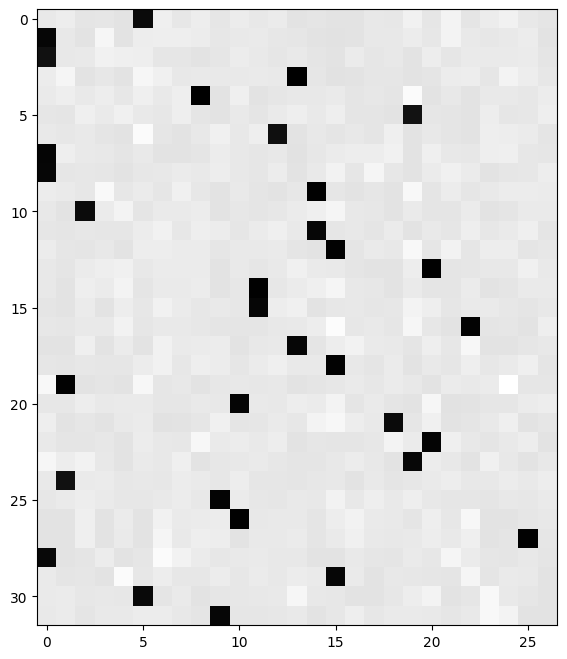

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

* dlogits is the probability matrix of the forward pass, where the black dots in the image above are the entries where we subtracted a 1
* Let's look at the first row of the probabilities and dlogits 

In [34]:
F.softmax(logits, 1)[0]

tensor([0.0358, 0.0539, 0.0206, 0.0261, 0.0115, 0.0592, 0.0626, 0.0289, 0.0540,
        0.0257, 0.0519, 0.0321, 0.0456, 0.0119, 0.0195, 0.0170, 0.0154, 0.0317,
        0.0280, 0.0722, 0.0218, 0.0812, 0.0194, 0.0487, 0.0730, 0.0326, 0.0200],
       grad_fn=<SelectBackward0>)

In [35]:
dlogits[0] * n

tensor([ 0.0358,  0.0539,  0.0206,  0.0261,  0.0115, -0.9408,  0.0626,  0.0289,
         0.0540,  0.0257,  0.0519,  0.0321,  0.0456,  0.0119,  0.0195,  0.0170,
         0.0154,  0.0317,  0.0280,  0.0722,  0.0218,  0.0812,  0.0194,  0.0487,
         0.0730,  0.0326,  0.0200], grad_fn=<MulBackward0>)

* We see that ```dlogits``` is exactly equal to the probabilities, except for the correct probability according to the label, where we subtracted 1
* Notice that if we take the first row of ```dlogits``` and sum it, it will be equal to 0, because probabilities sum to 1 and we subtract 1 from one position

In [36]:
dlogits[0].sum()

tensor(-3.0268e-09, grad_fn=<SumBackward0>)

* Thus, we can think of the rows of pulling down on the probabilities of the incorrect characters and pulling up on the correct one
* These pushes and pulls sum to zero, so the repulsion and the retraction are equal
* the rest of the neural net, specifically the weights and biases give in to this tuck, as everything is mathematically connected
* And the amount of push and pull is proportional to the probabilities in the forward pass, so if an incorrect answer got a high probability, it will be pushed down by that amount
* In turn, if the correct character got a high probability, e.g. near 1, then subtracting by 1 leaves a small correction force


## Excercie 3: Optimize Batchnorm Backward Pass
* Like with the cross entropy layer, we will derive the batch normalization formula wrt. the output of the linear layer
* The formula for the batch normalization layer is as follows

  $\Large \mu_B = \frac{1}{m} \sum_i^m x_i $
  
  $\Large \sigma_B^2 = \frac{1}{m-1} \sum_i^m (x_i - \mu_B)^2$ // bessel correction

  $\Large \hat{x}_i = \frac{(x_i - \mu_B)}{\sqrt{\sigma_B^2 + \epsilon}}$

  $\Large y_i = \gamma \cdot \hat{x}_i + \beta$

* We will compute the following derivative

  $\Large \frac{\partial loss}{\partial x_i}$

* and we already have

  $\Large \frac{\partial loss}{\partial y_i}$

* We will derive in the following order:

  $\Large \frac{\partial loss}{\partial y_i}\frac{\partial y_i}{\partial \hat{x}_i},
          \frac{\partial loss}{\partial \hat{x}_i}\frac{\partial \hat{x}_i}{\partial \sigma_B^2},
          \frac{\partial loss}{\partial \hat{x}_i}\frac{\partial \hat{x}_i}{\partial \mu_B},
          \frac{\partial loss}{\partial \sigma_B^2}\frac{\partial \sigma_B^2}{\partial \mu_B},
          \frac{\partial loss}{\partial \hat{x}_i}\frac{\partial \hat{x}_i}{\partial x_i},
          \frac{\partial loss}{\partial \sigma_B^2}\frac{\partial \sigma_B^2}{\partial x_i},
          \frac{\partial loss}{\partial \mu_B}\frac{\partial \mu_B}{\partial x_i}$


* Here are the derivatives

  $\Large \frac{\partial loss}{\partial \hat{x}_i} = \frac{\partial loss}{\partial y_i} \frac{\partial}{\partial \hat{x}_i} [ \gamma \hat{x}_i + \beta ] = \frac{\partial loss}{\partial y_i} \gamma $
  
  $\Large \frac{\partial loss}{\partial \sigma_B^2} = \sum_i \frac{\partial loss}{\partial \hat{x}_i}\frac{\partial }{\partial \sigma_i^2}[\frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}] = -\frac{1}{2}\gamma \sum_i \frac{\partial loss}{\partial y_i} (x_i-\mu_B) (\sigma_B^2 + \epsilon)^{-\frac{3}{2}}$

  $\Large \frac{\partial loss}{\partial \mu_B} = (\sum_i \frac{\partial loss}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\mu_B}) + \frac{\partial loss}{\partial \sigma_B^2}\frac{\partial \sigma_B^2}{\partial \mu_B}$

* We'll derive the two addends separately, starting with the first

  $\Large \frac{\partial }{\partial \mu_B}[\frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}] = -(\sigma_B^2 + \epsilon)^{-\frac{1}{2}}$

* Then the second

  $
  \begin{align}
  \frac{\partial}{\partial \mu_B}[\frac{1}{m}\sum_i (x_i - \mu_B)^2 ] &= -\frac{2}{m-1}\sum_i^m (x_i - \mu_B) \\
   &= -\frac{2}{m-1} (\sum_i^m x_i - \sum_i^m \mu_B) \\
   &= -\frac{2}{m-1} (\sum_i^m x_i - m \mu_B) \\
   &= -\frac{2m}{m-1} (\frac{1}{m} \sum_i^m x_i - \mu_B)) \\
   &= -\frac{2m}{m-1} (\mu_B - \mu_B)) \\
   &= 0
  \end{align}
   $
* Using our results in the original derivation

  $\Large \frac{\partial loss}{\partial \mu_B} = -\sum_i \frac{\partial loss}{\partial y_i}\gamma (\sigma_B^2 + \epsilon)^{-\frac{1}{2}}$

* Now on to the largest derivation: $x_i$

  $\Large \frac{\partial loss}{\partial x_i} = \frac{\partial loss}{\partial \hat{x}_i} \frac{\partial \hat{x}_i}{\partial x_i} + \frac{\partial loss}{\partial \sigma_B^2} \frac{\partial \sigma_B^2}{\partial x_i} + \frac{\partial loss}{\partial \mu_B} \frac{\partial \mu_B}{\partial \partial x_i}$ 

* Again, let's break it down per addend

$
\begin{align}
\frac{\partial \hat{x}_i}{\partial x_i} &= \frac{\partial}{\partial x_i}[\frac{(x_i - \mu_B)}{\sqrt{\sigma_B^2 + \epsilon}}] \\
                                        &= (\sigma_B^2 + \epsilon)^{-\frac{1}{2}}
\end{align}
$


$
\begin{align}
\frac{\partial \sigma_B^2}{\partial x_i} &= \frac{\partial}{\partial x_i}[\frac{1}{m-1}\sum_j^m (x_j - \mu_B)^2] \\
                                         &= \frac{2}{m-1}(x_i - \mu_B)
\end{align}
$

$
\begin{align}
\frac{\partial \mu_B}{\partial x_i} &= \frac{\partial}{\partial x_i}[\frac{1}{m}\sum_j^m x_i] \\
                                    &= \frac{1}{m}
\end{align}
$


* We insert our results back into the large formula

  $\Large \frac{\partial loss}{\partial x_i} = \frac{\partial loss}{\partial \hat{x}_i} (\sigma_B^2 + \epsilon)^{-\frac{1}{2}} + \frac{\partial loss}{\partial \sigma_B^2} (\frac{2}{m-1}(x_i - \mu_B)) + \frac{\partial loss}{\partial \mu_B} \frac{1}{m}$ 

* And we expand the results that we achieved before

  $\Large \frac{\partial loss}{\partial x_i} = \frac{\partial loss}{\partial y_i}\gamma (\sigma_B^2 + \epsilon)^{-\frac{1}{2}} + -\frac{1}{2}\gamma (\sum_j \frac{\partial loss}{\partial y_j} (x_j-\mu_B) (\sigma_B^2 + \epsilon)^{-\frac{3}{2}}) (\frac{2}{m-1}(x_i - \mu_B)) -\sum_j \frac{\partial loss}{\partial y_j}\gamma (\sigma_B^2 + \epsilon)^{-\frac{1}{2}} \frac{1}{m}$ 

* We will now simplify with the goal to reuse calculations that we already computed
* Every term has $(\sigma_B^2 + \epsilon)^{-\frac{1}{2}}$
* I don't know why, but Andrej is also factoring out $\frac{1}{m}$
* In the middle term, the $(\sigma_B^2 + \epsilon)^{-\frac{3}{2}}=\frac{1}{\sqrt{(\sigma_B^2 + \epsilon)}^3}$ is factored into three $\frac{1}{\sqrt{(\sigma_B^2 + \epsilon)}}$
* One $\frac{1}{\sqrt{(\sigma_B^2 + \epsilon)}}$ is factored out of the whole sum, one remains where it is and one is moved to the neighboring term to be able to reduce it to $\hat{x}_i$

  $\Large = \frac{\partial loss}{\partial y_i}\gamma (\sigma_B^2 + \epsilon)^{-\frac{1}{2}} + -\frac{1}{\cancel{2}\sqrt{(\sigma_B^2 + \epsilon)}}\gamma \sum_j \frac{\partial loss}{\partial y_j} \frac{(x_j-\mu_B)}{\sqrt{(\sigma_B^2 + \epsilon)}} (\frac{\cancel{2}}{m-1}\frac{(x_j-\mu_B)}{\sqrt{(\sigma_B^2 + \epsilon)}}) -\sum_j \frac{\partial loss}{\partial y_j}\gamma (\sigma_B^2 + \epsilon)^{-\frac{1}{2}}\frac{1}{m}$ 

  $\Large = \frac{(\sigma_B^2 + \epsilon)^{-\frac{1}{2}}}{m}\gamma(\frac{\partial loss}{\partial y_i} m - (\frac{m}{m-1}\hat{x}_i)(\sum_j \frac{\partial loss}{\partial y_j} \hat{x}_j)-\sum_j \frac{\partial loss}{\partial y_j})$ 

### In Code

In [37]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0) - dhpreact.sum(0))

In [38]:
cmp('dhprebn', dhprebn, hprebn)

dhprebn         | exact False | approximate: True  | maxdiff: 9.313225746154785e-10


## Excercise 4: Put it all together!
* We will now train the neural net using our own backprop code and compare to the result that torch give us

In [ ]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd)               , generator = g)
W1 = torch.randn((block_size*n_embd, n_hidden)     , generator = g) * 5/3 / ((block_size*n_embd)**0.5) # kaimin initialization to avoid contraction
b1 = torch.randn((n_hidden)                        , generator = g) * 0.1
W2 = torch.randn((n_hidden, vocab_size)            , generator = g) * 0.1  # make less confident
b2 = torch.randn((vocab_size)                      , generator = g) * 0.1  # not zero to unmask gradient errors

bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
n = batch_size # shorter name for use in expressions
lossi = []

In [ ]:
for i in range(max_steps):
    xi = torch.randint(0, len(words), (batch_size, ), generator = g)
    Xb, Yb = Xtr[xi], Ytr[xi]
    # forward pass "chunkated" into smaller steps that are possible to backward one at a time
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    # Linear Layer 1
    hprebn = embcat @ W1 + b1
    # Batchnorm Layer
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # Non Linearity
    h = torch.tanh(hpreact)
    # Linear layer 2
    logits = h @ W2 + b2
    # cross entropy loss
    loss = F.cross_entropy(logits, Yb)
    
    # PyTorch backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # YOUR CODE HERE
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /=  n
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dhpreact = (1. - h*h) * dh
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnraw = (bngain * dhpreact)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dbndiff = bnvar_inv * dbnraw
    dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
    dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
    dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
    dbndiff += 2*bndiff * dbndiff2
    dbnmeani = -dbndiff.sum(0, keepdim=True)
    dhprebn = (1/hprebn.shape[0])*torch.ones_like(hprebn)*dbnmeani
    dhprebn += dbndiff
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    demb = dembcat.view(-1, block_size, n_embd)
    dC =  torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p, grad in zip(parameters, grads):
#        p.data += -lr * p.grad
        p.data += -lr * grad

    # track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

* After training, we calculate the mean and var for the whole training set to be used in the forward pass that calculates the loss of a whole set

In [ ]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')